In [30]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from statistics import mean
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import shap
from scipy.stats import ranksums

In [31]:
MR = [100]
N_genes = 100  # total no. of genes
N_TFs = N_genes

GENE_INDEX = [50]

n_estimators=[500]  # number of trees in the forest
criterion='squared_error'  # variance reduction equivalent
max_features = ['sqrt'] # max no. of features to use in each split
random_state = 42  # for reproducibility

In [32]:
#rf_results = pd.DataFrame(columns=['MR', 'FI', 'N_EST', 'MAX_FEATURES','BOOTSTRAPPING', 'AUPRC', 'AUROC', 'MEAN_AUROC','STD_AUROC','MEAN_AUPRC','STD_AUPRC', 'p-value', 'BOOSTING'])
#rf_results.to_csv("results/grn_rf_gb_results.csv", index=False)     


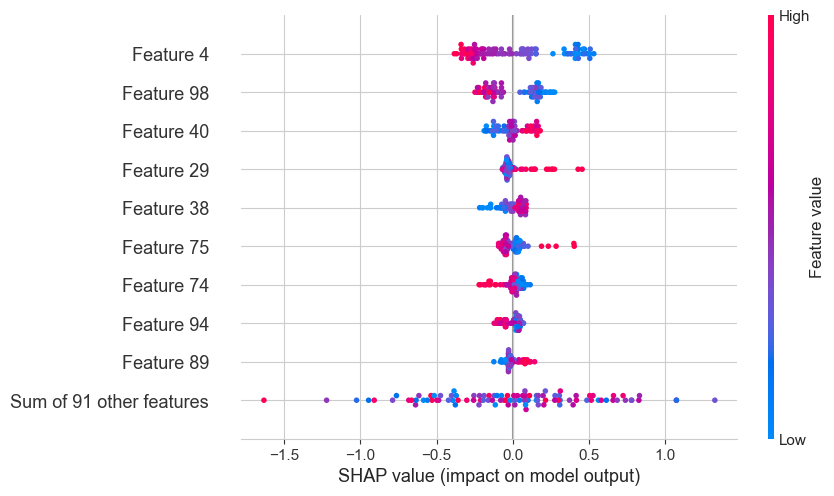

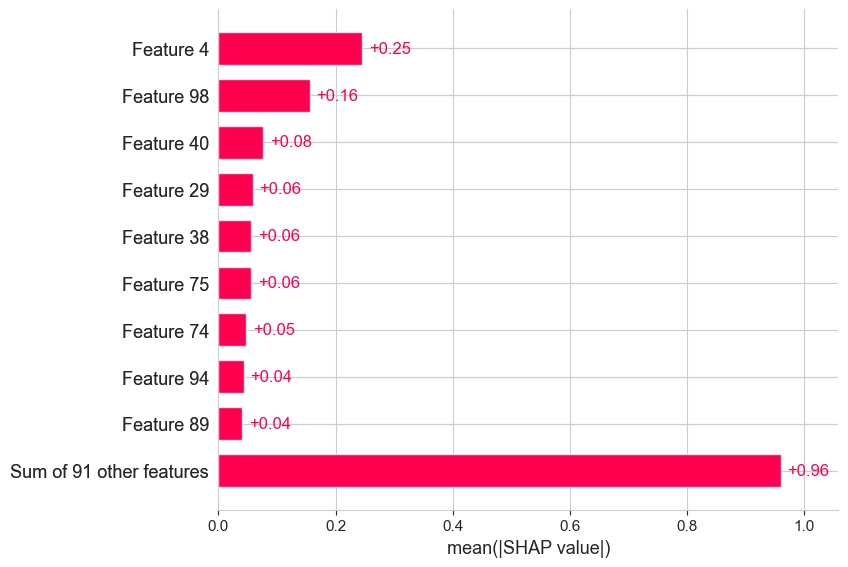

In [33]:
for mr in MR:
    for n_est in n_estimators:
        for m_f in max_features:
                
                # rf_results = pd.read_csv("results/grn_rf_gb_results.csv", header=0)
                
                data_file = ("data/{}_mr_50_cond/simulated_noNoise.txt").format(mr)
                grn_file = ("data/{}_mr_50_cond/bipartite_GRN.csv").format(mr)

                data = pd.read_csv(data_file, sep="\t", header=0)
                grn_df = pd.read_csv(grn_file, sep = ",", header = None, names=['TF_ID', 'G_ID'])
                grn_df['class'] = 1

                # Normalize Expression data to unit-variance
                data_n = StandardScaler(with_mean=False).fit_transform(data.to_numpy())

                # Initialize matrices
                W = np.zeros(shape=(N_genes,N_TFs))
                W_shap = np.zeros(shape=(N_genes,N_TFs))
                Fscores = np.zeros(shape=(N_genes,))

                for j in GENE_INDEX:
                    # read TF and gene expression data X and Gj
                    X, Gj= data_n[:,:N_TFs], data_n[:,N_genes+j]

                    # fit an RF model to predict gene expression from TF
                    M_rf_gb = GradientBoostingRegressor(criterion=criterion, n_estimators=n_est, loss='squared_error', max_features=m_f, random_state=random_state).fit(X,Gj)
                    # train score
                    Fscores[j] = M_rf_gb.score(X,Gj)

                    # Get the weights for all edges connecting TFs to gene j
                    W[j,:] = M_rf_gb.feature_importances_

                    # look at feature importance based on SHAP values
                    explainer = shap.TreeExplainer(M_rf_gb)
                    shap_values = explainer(X)
                    W_shap[j,:] = np.mean(np.abs(shap_values.values), axis=0)

                    shap.plots.beeswarm(shap_values, max_display=10)

                    shap.plots.bar(shap_values.abs.mean(0), max_display=10)

                    pass
                    


In [34]:
grn_df[grn_df["G_ID"] == N_genes+GENE_INDEX[0]]

,TF_ID,G_ID,class
19,4,150,1
194,40,150,1
479,98,150,1
